# Data cleaning and merging dataframes

## Loading multiple datasets

In [432]:
import pandas as pd
pd.set_option('display.float_format', lambda x: '%.2f' % x)
pd.set_option('display.max_rows', 1000)


path = 'Users/User/Desktop/wbs_datascience/git_repositories/Pandas/notebooks_eniac/'
orderlines = pd.read_csv("orderlines.csv")
orders = pd.read_csv("orders.csv")
brands = pd.read_csv("brands.csv")
products = pd.read_csv("products.csv")


# reading files from google drive based on one example
'''
# orderlines.csv
url = 'put here the url of the file' 
path = 'https://drive.google.com/uc?export=download&id='+url.split('/')[-2]
orderlines = pd.read_csv(path)'''


"\n# orderlines.csv\nurl = 'put here the url of the file' \npath = 'https://drive.google.com/uc?export=download&id='+url.split('/')[-2]\norderlines = pd.read_csv(path)"

### Another way to read the files: 

Using `os` and a loop to read all the files from a directory. It's also possible to read only files with a certain extension (like `.csv`):

In [433]:
# import pandas as pd
# import os
# path = '../data/eniac/'
# path, dirs, files = next(os.walk(path))
# #print(files)

# # remove non-csv files
# for file in files:
#     if not file.endswith("csv"):
#         files.remove(file)

In [434]:
# # create empty list 
# df_list = []

# # append datasets to the list
# for file in files:
#     temp_df = pd.read_csv(path + file, sep=',')
#     df_list.append(temp_df)

# # show results
# products, orders, orderlines, brands = df_list[0], df_list[1], df_list[2], df_list[3]

## Check for Data Quality

### Check for missing values

In [435]:
# we can check missing values column for orderlines 
orderlines.isna().sum()

id                  0
id_order            0
product_id          0
product_quantity    0
sku                 0
unit_price          0
date                0
dtype: int64

In [436]:
# or for the whole dataframe
orderlines.isna().sum().sum()

0

In [437]:
# with info(), we also can easily check for the datatype
orderlines.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 293983 entries, 0 to 293982
Data columns (total 7 columns):
 #   Column            Non-Null Count   Dtype 
---  ------            --------------   ----- 
 0   id                293983 non-null  int64 
 1   id_order          293983 non-null  int64 
 2   product_id        293983 non-null  int64 
 3   product_quantity  293983 non-null  int64 
 4   sku               293983 non-null  object
 5   unit_price        293983 non-null  object
 6   date              293983 non-null  object
dtypes: int64(4), object(3)
memory usage: 15.7+ MB


In [438]:
# --> unit price should be fliat, date should have a date datatype

In [439]:
# check missing for orders
orders.isna().sum()

order_id        0
created_date    0
total_paid      5
state           0
dtype: int64

In [440]:
# --> 5 missing values in the total_paid column

In [441]:
# the .info() method also tells us the "Non-Null Count" for each column
orders.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 226909 entries, 0 to 226908
Data columns (total 4 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   order_id      226909 non-null  int64  
 1   created_date  226909 non-null  object 
 2   total_paid    226904 non-null  float64
 3   state         226909 non-null  object 
dtypes: float64(1), int64(1), object(2)
memory usage: 6.9+ MB


In [442]:
# --> created dat is not defined as datetime object

In [443]:
brands.isna().sum()

short    0
long     0
dtype: int64

In [444]:
products.isna().sum()

sku             0
name            0
desc            7
price          46
promo_price     0
in_stock        0
type           50
dtype: int64

In [445]:
# --> we can see missing values in desc, price and and type

### Check for Duplicates

The presence of duplicate rows is generally a sign that the data is not clean, and will deserve further exploration.

In [446]:
orderlines.duplicated().sum()

0

In [447]:
orders.duplicated().sum()

0

In [448]:
brands.duplicated().sum()

0

In [449]:
products.duplicated().sum()

8746

In [450]:
products.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19326 entries, 0 to 19325
Data columns (total 7 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   sku          19326 non-null  object
 1   name         19326 non-null  object
 2   desc         19319 non-null  object
 3   price        19280 non-null  object
 4   promo_price  19326 non-null  object
 5   in_stock     19326 non-null  int64 
 6   type         19276 non-null  object
dtypes: int64(1), object(6)
memory usage: 1.0+ MB


In [451]:
# --> a lot of duplicates in products table. 8746 rows from 19326 contain duplicates
# --> price and promo_price are loaded as objects, why? 

### Data cleanliness - initial assessment

Based on our initial exploration, we know we will need to deal with some missing values. The biggest issue so far are the duplicates on the `products` DataFrame. Here are some aspects that we will need to fix or, at least, explore further:

* **products**: 
    * `price` and `promo_price` are loaded as objects. They should be floats. 
    * Missing values: 
        * `description`: 7 missing values. Maybe that could be inferred from the product name?
        * `price`: the missing values could be filled from the `orderlines` dataset. But first we will need to clean it. 
        * `type`: we don't need the type column for analysis, so this doesn't concern us 
    * Duplicates: a total of 8746 duplicates seems to indicate this DataFrame has been seriously corrupted.
    
* **orders**: 
    * `created_date` should have a date data type. Then, it would be a good quality check to see if the created date for `orders` matches with the created dates for `orderlines`. 
    
* **orderlines**: 
    * `unit_price` has to be a float, something is wrong there. 
    * `date` has to be transformed to a date data type. Then, as we said, check that it with matches with the `orders` dataset. 
    
* **brands**: looks fine. 

Where do we have to start? 

1. **Data consistency:** Since `orders` and `orderlines` seem very crucial to the analysis, we will start by cleaning them and checking that the information present in both DataFrames match.

2. **The "products mess":** This file seems to have many issues. We will leave it out for now and perform a proper exploration later to understand better what's going on there.

## Cleaning and matching orders and orderlines

The data consistency check we will do with `orderlines` will involve two steps: 

* the initial and last dates of the orders should be the same for orders and orderlines
* the sum of `total_paid` on both datasets should be the same

Let's start by transforming the `created_date` of the orders DataFrame and looking for its earliest and latest values:

## Cleaning orders table for enabling data consistency with orderlines

In [452]:
# change date datatype
orders['created_date'] = pd.to_datetime(orders['created_date'])

In [453]:
# earliest value
min(orders['created_date'])

Timestamp('2017-01-01 00:07:19')

In [454]:
# latest value
max(orders['created_date'])

Timestamp('2018-03-14 13:58:36')

Now we will look at the overall sum of `total_paid` for the orders table:

In [455]:
sum(orders['total_paid'])

nan

In [456]:
# --> we get a nan as result because we still have missing values in this column. 
# --> We can explore them and see how they are all "Pending" orders:

In [457]:
orders.loc[orders['total_paid'].isna()]

,order_id,created_date,total_paid,state
127701,427314,2017-11-20 18:54:39,NaN,Pending
132013,431655,2017-11-22 12:15:24,NaN,Pending
147316,447411,2017-11-27 10:32:37,NaN,Pending
148833,448966,2017-11-27 18:54:15,NaN,Pending
149434,449596,2017-11-27 21:52:08,NaN,Pending


Since these orders are only a tiny fraction and there's a valid reason why the `total_paid` value is missing, we will simply exclude them from the dataset:

In [458]:
orders.dropna(inplace=True)

Now the dataset is clean. And the total paid is: 

In [459]:
sum(orders['total_paid'])

129159615.06991275

## Cleaning orderlines for data consistency reasons

Following our data consistency check, will now gather in the orderlines DataFrame the same information we got from orders:

* the initial and last dates
* the sum of `total_paid`


First let's transform our date time:

### Check initial and last dates for both tables: 

In [460]:
orderlines['date'] = pd.to_datetime(orderlines['date'])

In [461]:
min(orderlines['date'])
# orders: Timestamp('2017-01-01 00:07:19')

Timestamp('2017-01-01 00:07:19')

In [462]:
max(orderlines['date'])
# orders: Timestamp('2018-03-14 13:58:36')

Timestamp('2018-03-14 13:58:36')

**It's a match!**

### Now we check the `total_paid` for orderlines: 

In [463]:
orderlines.head(3)

,id,id_order,product_id,product_quantity,sku,unit_price,date
0,1119109,299539,0,1,OTT0133,18.99,2017-01-01 00:07:19
1,1119110,299540,0,1,LGE0043,399.00,2017-01-01 00:19:45
2,1119111,299541,0,1,PAR0071,474.05,2017-01-01 00:20:57



To get this value, we will have to calculate a new column, total price. It would be `product_quantity` * `unit_price` for each row. This operation will require that both columns have a numeric data type, so we first have to transform `unit_price` into a numeric data type

In [464]:
# orderlines['product_quantity']*pd.to_numeric(orderlines['unit_price'])

From the error message, 

> "Unable to parse string '1.137.99' at position 6"

it seems that our dataset has some problems with the thousands separators: they were encoded as dots, and Python & pandas only admit one dot per number: the _decimal_ separator!

The first thing we will do is to count how many dots appear for each `unit_price` value, using string operations. If there are two or more dots for a value, we will consider it corrupted — and either try to fix it, or remove it completely.

### Detour: clean the `unit_price` column before calculating the `total_paid`: 

In [465]:
# we create a copy of the dataset so the original one doesn't get corrupted
ol_temp = orderlines.copy()

# create a new column with the amount of dots in the unit_price column
ol_temp['dots'] = orderlines['unit_price'].str.count('\.') 
# show the rows with more than one dot
ol_temp.query('dots > 1')

,id,id_order,product_id,product_quantity,sku,unit_price,date,dots
6,1119115,299544,0,1,APP1582,1.137.99,2017-01-01 01:17:21,2
11,1119126,299549,0,1,PAC0929,2.565.99,2017-01-01 02:07:42,2
15,1119131,299553,0,1,APP1854,3.278.99,2017-01-01 02:14:47,2
43,1119195,299582,0,1,PAC0961,2.616.99,2017-01-01 08:54:00,2
59,1119214,299596,0,1,PAC1599,2.873.99,2017-01-01 09:53:11,2
...,...,...,...,...,...,...,...,...
293862,1649999,452946,0,1,APP2075,2.999.00,2018-03-14 13:03:33,2
293887,1650045,527321,0,1,PAC2148,3.497.00,2018-03-14 13:10:15,2
293889,1650050,527324,0,1,PAC2117,3.075.00,2018-03-14 13:10:56,2
293911,1650088,527342,0,1,APP2492,1.329.00,2018-03-14 13:24:51,2


Let's remove all the dots for all the `unit_price`, and then add a dot before the last 2 digits to all the rows. Then we will transform it into numeric values.

##### step 1: remove all dots
a) A "corrupted" price like `1.137.99`	will become `113799`

b) A correct price like `37.99`	will become `3799`

##### step 2: add dots two digits before the end of the number
a) The "corrupted" price will go from `113799` to `1137.99`

b) The correct price will go from `3799` back to `37.99`.

In [466]:
# step 1: to remove the dots, we replace them for... nothing
orderlines = orderlines.assign(unit_price_nd = orderlines['unit_price'].str.replace('\.','', regex=True))
orderlines.head()

,id,id_order,product_id,product_quantity,sku,unit_price,date,unit_price_nd
0,1119109,299539,0,1,OTT0133,18.99,2017-01-01 00:07:19,1899
1,1119110,299540,0,1,LGE0043,399.00,2017-01-01 00:19:45,39900
2,1119111,299541,0,1,PAR0071,474.05,2017-01-01 00:20:57,47405
3,1119112,299542,0,1,WDT0315,68.39,2017-01-01 00:51:40,6839
4,1119113,299543,0,1,JBL0104,23.74,2017-01-01 01:06:38,2374


In [467]:
# step 2.1: we first separate all numbers between the part that goes before the
# decimal point (integers) and the part that goes afterwards (decimals)
orderlines['integers'] = orderlines['unit_price_nd'].str[:-2]
orderlines['decimals'] = orderlines['unit_price_nd'].str[-2:]
orderlines.head()

,id,id_order,product_id,product_quantity,sku,unit_price,date,unit_price_nd,integers,decimals
0,1119109,299539,0,1,OTT0133,18.99,2017-01-01 00:07:19,1899,18,99
1,1119110,299540,0,1,LGE0043,399.00,2017-01-01 00:19:45,39900,399,00
2,1119111,299541,0,1,PAR0071,474.05,2017-01-01 00:20:57,47405,474,05
3,1119112,299542,0,1,WDT0315,68.39,2017-01-01 00:51:40,6839,68,39
4,1119113,299543,0,1,JBL0104,23.74,2017-01-01 01:06:38,2374,23,74


In [468]:
# step 2.2: we now concatenate those two parts of the number, with a dot in between
orderlines['new_unit_price'] = orderlines['integers'] + '.' + orderlines['decimals']
orderlines.head()

,id,id_order,product_id,product_quantity,sku,unit_price,date,unit_price_nd,integers,decimals,new_unit_price
0,1119109,299539,0,1,OTT0133,18.99,2017-01-01 00:07:19,1899,18,99,18.99
1,1119110,299540,0,1,LGE0043,399.00,2017-01-01 00:19:45,39900,399,00,399.00
2,1119111,299541,0,1,PAR0071,474.05,2017-01-01 00:20:57,47405,474,05,474.05
3,1119112,299542,0,1,WDT0315,68.39,2017-01-01 00:51:40,6839,68,39,68.39
4,1119113,299543,0,1,JBL0104,23.74,2017-01-01 01:06:38,2374,23,74,23.74


### End of detour - back to converting and calculating `total_paid` to compare it with the value in the orders table: 

In [469]:
orderlines['unit_price'] = pd.to_numeric(orderlines['new_unit_price'])
orderlines.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 293983 entries, 0 to 293982
Data columns (total 11 columns):
 #   Column            Non-Null Count   Dtype         
---  ------            --------------   -----         
 0   id                293983 non-null  int64         
 1   id_order          293983 non-null  int64         
 2   product_id        293983 non-null  int64         
 3   product_quantity  293983 non-null  int64         
 4   sku               293983 non-null  object        
 5   unit_price        293983 non-null  float64       
 6   date              293983 non-null  datetime64[ns]
 7   unit_price_nd     293983 non-null  object        
 8   integers          293983 non-null  object        
 9   decimals          293983 non-null  object        
 10  new_unit_price    293983 non-null  object        
dtypes: datetime64[ns](1), float64(1), int64(4), object(5)
memory usage: 24.7+ MB


In [470]:
# drop 'auxiliary' columns
orderlines.drop(['unit_price_nd','decimals','integers','new_unit_price'], axis=1, inplace=True)

# create a new column "total_price" by multiplying product_quantity times unit_price
orderlines['total_price'] = orderlines['product_quantity'] * orderlines['unit_price']

# sum of the new column "total_price":
orderlines['total_price'].sum()

128776222.02999999

Sadly, it does not match exactly with the sum of `total_paid` from orders:

In [471]:
orders['total_paid'].sum()

129159615.07000001

The mismatch is about 383 thousand dollars, a non-neglegible amount of money:

In [472]:
(orderlines['total_price'].sum()) - (orders['total_paid'].sum())

-383393.04000002146

How can we figure out where does the difference come from? 

## Matching `orders` and `orderlines`: Explore the price missmatch

It is possible that some orders exist in one dataset but not in the other one. This would be a potential source for this price mismatch. Let's find out!

In [473]:
orderlines["check_orders"]=orderlines['id_order'].isin(orders['order_id'])
orderlines.head()

,id,id_order,product_id,product_quantity,sku,unit_price,date,total_price,check_orders
0,1119109,299539,0,1,OTT0133,18.99,2017-01-01 00:07:19,18.99,True
1,1119110,299540,0,1,LGE0043,399.00,2017-01-01 00:19:45,399.00,True
2,1119111,299541,0,1,PAR0071,474.05,2017-01-01 00:20:57,474.05,True
3,1119112,299542,0,1,WDT0315,68.39,2017-01-01 00:51:40,68.39,True
4,1119113,299543,0,1,JBL0104,23.74,2017-01-01 01:06:38,23.74,True


In [474]:
orderlines.query("check_orders==False").count()

id                  240
id_order            240
product_id          240
product_quantity    240
sku                 240
unit_price          240
date                240
total_price         240
check_orders        240
dtype: int64

It looks like 240 rows in `orderlines` come from orders not present in the `orders` dataset. This is quite inconsistent, since the `orders` dataset should be the one and only source of truth for orders: For now, let's just remove those "ghost" orders:

In [475]:
orderlines = orderlines.query("check_orders==True")

Now let's look at this problem in the opposite direction: are there orders in the `orders` dataset not present in `orderlines`?

In [476]:
orders["check_orders"]=orders['order_id'].isin(orderlines['id_order'])
orders.head()

,order_id,created_date,total_paid,state,check_orders
0,241319,2017-01-02 13:35:40,44.99,Cancelled,True
1,241423,2017-11-06 13:10:02,136.15,Completed,True
2,242832,2017-12-31 17:40:03,15.76,Completed,True
3,243330,2017-02-16 10:59:38,84.98,Completed,True
4,243784,2017-11-24 13:35:19,157.86,Cancelled,True


In [477]:
orders.query("check_orders==False").count()

order_id        22213
created_date    22213
total_paid      22213
state           22213
check_orders    22213
dtype: int64

There are more than 22000 orders in the `orders` dataset that are not present on the `orderlines` dataset!!! We can try to find out why by looking at the state of these orders:

In [478]:
(orders
 .assign(check_orders = orders['order_id'].isin(orderlines['id_order']))
 .query("check_orders==False")
 ['state'].value_counts())

Place Order        12304
Shopping Basket     9810
Completed             45
Cancelled             41
Pending               13
Name: state, dtype: int64

It looks like most of them are orders that were not fully completed: the products were left in the shopping basket or the order was "placed" but maybe not paid (hence the state "Place Order". Some of them were "Completed", though. 

This will require further research, and we might have to come back to these orders if we have to explore consumer behaviour for now, for the sake of data consistency, let's drop all of these unmatched orders:

In [479]:
orders = (orders
          .assign(check_orders = orders['order_id'].isin(orderlines['id_order']))
          .query("check_orders==True")
         )

Let's now check again if the total paid matches:

In [480]:
orders['total_paid'].sum()

129130877.18

In [481]:
orderlines['total_price'].sum()

128659393.77

STILL NOT MATCHING!!! And actually, the difference got larger. So we'll have to further explore: 

In [482]:
(orderlines['total_price'].sum()) - (orders['total_paid'].sum())

-471483.4100000113

## Solving the price mismatch

Let's merge both datasets and compare, order by order, the `total_price`. We will call this new merged dataset `orders_info`.

*Note: Remember that the `orderlines` dataset contains one row per product bought: an order where 3 different products were purchased will result in 3 rows there. Therefore, to merge `orderlines` with `orders`, we have to group `orderlines` by its `id_order` and aggregate it by taking the sum of the `total_price`.

In [483]:
orders_info = (
orderlines
    .groupby('id_order')
    .agg({'total_price':'sum'})
    .merge(orders, how='left', left_on='id_order', right_on='order_id')
    .copy()
)
orders_info.filter(['id_order', 'total_price', 'total_paid'])

,total_price,total_paid
0,44.99,44.99
1,129.16,136.15
2,10.77,15.76
3,77.99,84.98
4,153.87,157.86
...,...,...
204686,42.99,42.99
204687,42.99,42.99
204688,141.58,141.58
204689,19.98,19.98


In [484]:
orders_info['price_difference'] = orders_info['total_price'] - orders_info['total_paid']
orders_info.sort_values('price_difference').head(30)

,total_price,order_id,created_date,total_paid,state,check_orders,price_difference
70971,90.99,376851,2017-07-13 12:58:52,90989.60,Shopping Basket,True,-90898.61
32392,79.98,334803,2017-03-13 20:41:31,79981.00,Shopping Basket,True,-79901.02
119473,42.99,431635,2017-11-22 12:01:15,42988.90,Shopping Basket,True,-42945.91
45740,12.90,349166,2017-04-24 11:40:42,12899.80,Shopping Basket,True,-12886.90
12387,10322.92,313023,2017-01-21 21:12:41,14648.91,Shopping Basket,True,-4325.99
145,84.55,297148,2017-01-01 16:42:24,4069.54,Completed,True,-3984.99
123,66.49,293308,2017-01-01 13:33:43,2635.47,Completed,True,-2568.98
191738,1674.60,512894,2018-02-16 13:25:30,3356.18,Completed,True,-1681.58
10981,1649.99,311490,2017-01-18 11:02:34,3299.98,Shopping Basket,True,-1649.99
188176,1291.60,508825,2018-02-16 11:21:44,2590.18,Completed,True,-1298.58


In [485]:
orders_info['price_difference'].describe()

count   204691.00
mean        -2.30
std        297.46
min     -90898.61
25%         -0.01
50%          0.00
75%          0.00
max      36159.90
Name: price_difference, dtype: float64

Looks like the maximum and minimun price differences are huge: some orders are really corrupted. But we also see from the mean and the quartiles that the price difference is neglegible for most orders.

<AxesSubplot:>

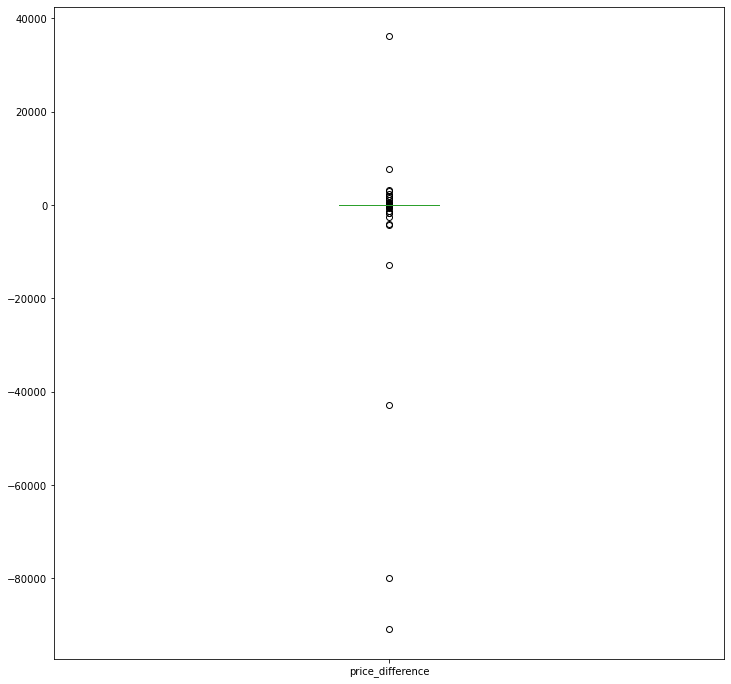

In [486]:
orders_info.boxplot("price_difference",   figsize=(12,12), grid=False)

## Remove outliers in price differences

Note: this solution does not completely achieve 100% trustable data, but the objective here is to end up with the best possible data with a limited amount of time, which makes a complete revision of the database protocols and the data pipelines is not feasable - and business questions are pending. Therefore we document and reporting this the data cleaning process, including the criteria for outliers in detail: 

<AxesSubplot:>

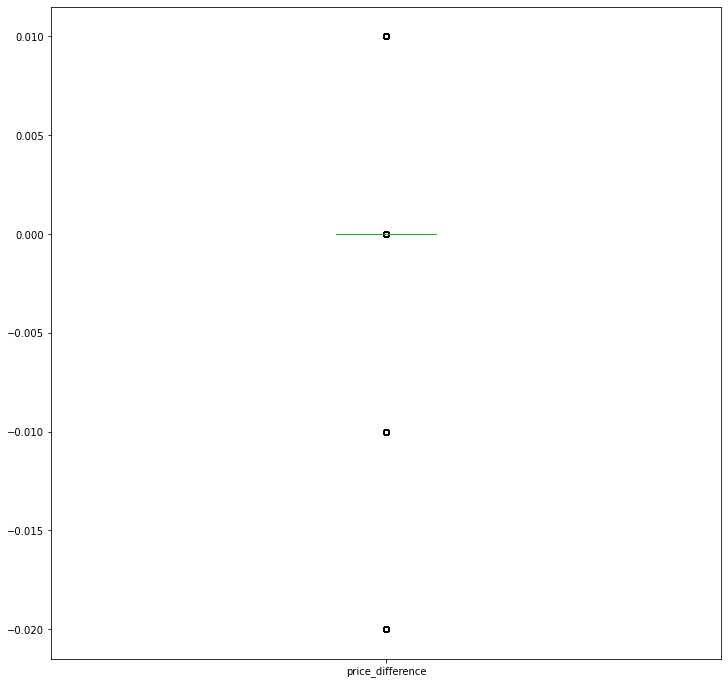

In [487]:
import numpy as np
q3, q1 = np.percentile(orders_info['price_difference'], [75 ,25])
iqr = q3 - q1
lower_bound = q1 -(1.5 * iqr) 
upper_bound = q3 +(1.5 * iqr)
#print(q3)
#print(q1)
#print(lower_bound)
#print(upper_bound)
#print(iqr)
price_difference_outliers_removed = orders_info.loc[(orders_info['price_difference'] >= lower_bound) & (orders_info['price_difference'] <= upper_bound)]
#price_difference_new_df.sort_values('price_difference').tail(10)
#price_difference_new.info()
#price_difference_new.info()
price_difference_outliers_removed.boxplot("price_difference",   figsize=(12,12), grid=False)

In [488]:
orders = price_difference_outliers_removed.copy()
orders.info()
orders.sort_values('price_difference').head(10)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 156882 entries, 0 to 204689
Data columns (total 7 columns):
 #   Column            Non-Null Count   Dtype         
---  ------            --------------   -----         
 0   total_price       156882 non-null  float64       
 1   order_id          156882 non-null  int64         
 2   created_date      156882 non-null  datetime64[ns]
 3   total_paid        156882 non-null  float64       
 4   state             156882 non-null  object        
 5   check_orders      156882 non-null  bool          
 6   price_difference  156882 non-null  float64       
dtypes: bool(1), datetime64[ns](1), float64(3), int64(1), object(1)
memory usage: 8.5+ MB


,total_price,order_id,created_date,total_paid,state,check_orders,price_difference
194213,35813.52,515661,2018-02-21 19:59:58,35813.54,Shopping Basket,True,-0.02
49961,30051.89,353742,2017-05-08 11:08:32,30051.91,Cancelled,True,-0.02
131470,9479.27,445263,2017-11-26 14:14:42,9479.29,Place Order,True,-0.02
153905,3813.90,470025,2017-12-22 23:37:16,3813.92,Shopping Basket,True,-0.02
194438,11537.17,515917,2018-02-22 10:37:22,11537.19,Shopping Basket,True,-0.02
121051,9080.14,433435,2017-11-24 12:17:33,9080.16,Completed,True,-0.02
126198,5378.36,439269,2017-11-24 14:00:38,5378.38,Shopping Basket,True,-0.02
95050,8414.33,404022,2017-09-24 19:30:44,8414.35,Shopping Basket,True,-0.02
146814,10245.58,462004,2017-12-13 17:32:56,10245.60,Shopping Basket,True,-0.02
92635,12747.00,401302,2017-09-18 14:19:05,12747.02,Shopping Basket,True,-0.02


In [489]:
orderlines.head()

,id,id_order,product_id,product_quantity,sku,unit_price,date,total_price,check_orders
0,1119109,299539,0,1,OTT0133,18.99,2017-01-01 00:07:19,18.99,True
1,1119110,299540,0,1,LGE0043,399.00,2017-01-01 00:19:45,399.00,True
2,1119111,299541,0,1,PAR0071,474.05,2017-01-01 00:20:57,474.05,True
3,1119112,299542,0,1,WDT0315,68.39,2017-01-01 00:51:40,68.39,True
4,1119113,299543,0,1,JBL0104,23.74,2017-01-01 01:06:38,23.74,True


In [511]:
orders.head()

,total_price,order_id,created_date,total_paid,state,check_orders,price_difference
0,44.99,241319,2017-01-02 13:35:40,44.99,Cancelled,True,0.00
5,149.00,245275,2017-06-28 11:35:37,149.00,Completed,True,0.00
7,79.99,245851,2017-04-04 20:58:21,79.99,Pending,True,0.00
11,153.54,247643,2017-05-26 11:50:35,153.54,Completed,True,0.00
13,140.99,251302,2017-05-10 12:27:33,140.99,Completed,True,0.00


In [490]:
# Save the data: 
orderlines.to_csv('orderlines_clean.csv', index=False)
orders.to_csv('orders_clean.csv', index=False)

## Cleaning products

Review of the problems: 

In [491]:
print(products.info(), "\n", "\n")
print("Missing values:", products.isna().sum(), "\n", "\n")
print("Duplicate rows:", products.duplicated().sum())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19326 entries, 0 to 19325
Data columns (total 7 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   sku          19326 non-null  object
 1   name         19326 non-null  object
 2   desc         19319 non-null  object
 3   price        19280 non-null  object
 4   promo_price  19326 non-null  object
 5   in_stock     19326 non-null  int64 
 6   type         19276 non-null  object
dtypes: int64(1), object(6)
memory usage: 1.0+ MB
None 
 

Missing values: sku             0
name            0
desc            7
price          46
promo_price     0
in_stock        0
type           50
dtype: int64 
 

Duplicate rows: 8746


Looking at this overview, we can see that there are different things that have to be changed: 

* Data types: 
    * `price` should be a float
    * `promo price` should be a float
* Duplicate rows: 
    * Remove Duplicates
* Missing values: 
    * `Description` maybe be inferred by the name
    * `price`. Is there a way to extract information from another table?
    * `type`. We can drop it. We don't need it for further analysis

### Remove Duplicates

In [492]:
products_temp = products.drop_duplicates('sku').copy()
products_temp.info()
print('\n')
print("\n", products.info()) 
print(products.duplicated().sum())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10579 entries, 0 to 19325
Data columns (total 7 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   sku          10579 non-null  object
 1   name         10579 non-null  object
 2   desc         10572 non-null  object
 3   price        10534 non-null  object
 4   promo_price  10579 non-null  object
 5   in_stock     10579 non-null  int64 
 6   type         10529 non-null  object
dtypes: int64(1), object(6)
memory usage: 661.2+ KB


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19326 entries, 0 to 19325
Data columns (total 7 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   sku          19326 non-null  object
 1   name         19326 non-null  object
 2   desc         19319 non-null  object
 3   price        19280 non-null  object
 4   promo_price  19326 non-null  object
 5   in_stock     19326 non-null  int64 
 6   type         19276 non-null 

In [493]:
# Difference of rows is equivalent to number of duplicates: 
19326-10579

8747

### Fix data types

- We Use a combination of boolean indexing with .loc and a string method to filter the rows with prices that haver more than two dots, explore them and make a final call: should we keep or remove these rows?

In [512]:
products_temp.sample(50)

,sku,name,desc,price,promo_price,in_stock,type,dots_promo_price
14959,SAM0110-A,"Open - Samsung S22F350FHU Monitor 22 ""Full HD ...",22 Eco Monitor mode for energy saving super sl...,129.99,997.822,0,1298,1.00
13443,TUC0286,ELEKTRO FLEX Tucano iPhone UltraSlim Case 8 Pl...,thin flexible sleeve with metallic shades for ...,19.90,13.99,1,11865403,1.00
14047,APP1877,"Apple MacBook Pro 15 ""Core i7 Touch Bar 29GHz ...",New MacBook Pro 15-inch Core i7 Touch Bar 29Gh...,4999.00,4.755.594,0,2158,0.00
13664,DLL0047,Dell E-series E2417H 24 FHD IPS DP VGA,Monitor 24 inch FHD with high vision support w...,196.60,165.989,0,1296,1.00
18366,BEL0338,Belkin Sport Armband Pro-Fit iPhone 8 Plus / 7...,Advanced fitness armband for iPhone 8 Plus / 7...,34.99,28.99,1,5405,1.00
11441,KIN0154,Kingston Secure Digital SDHC UHS Class 1 | 16 GB,SDHC Memory Card 16GB UHS Class 1 with speeds ...,15.99,92.807,1,57445397,1.00
17441,AP20324,Like new - Apple iPhone 7 Plus 32GB Gold,Apple iPhone 7 Plus Free Refurbished 32GB Colo...,779.00,6.590.023,0,85651716,0.00
15450,PAC2182,Pack Qnap TS-453b mini 4G NAS server 24TB (4x6...,NAS with HDMI 4K (3840x2160) 4-core processor ...,1639.05,12.233.681,0,12175397,1.00
15800,WAC0210,Wacom Bamboo Fineline 3 pointer White,Digital Pen with Bluetooth connectivity 1024 p...,59.90,499.899,1,1229,1.00
18293,BEL0353,Mixit Belkin USB Charging Cable C / C USB Rosa,USB charging cable USB-C-C MIXIT Belkin lets y...,19.99,179.903,1,1325,1.00


It seems this time that the problem in our products prices is different from the one we found on orderlines. 
How is it possible that we have more than 3 digits? 

My strategy would be: 

1. Replace missing values with a "special" string. In that case I will put "000.000" as it would represent that this value has a wrong format and has to be changed. This step is done to avoid future problems while cleaning the column price.
2. Create a new column called "price_split" with the values of price split by the `.`
3. Create a new column called "dots_count" counting the number of dots a price contains.

In [495]:
# create a new column with the amount of dots in the unit_price column
products_temp['dots_price'] = products_temp['price'].str.count('\.') 
products_temp['dots_promo_price'] = products_temp['price'].str.count('\.')

# Replace all missing values by '000.000': two ways to do it: 
#products_temp = products_temp.assign(price = products_temp['price'].fillna('000.000'))
products_temp['price'] = products_temp['price'].fillna('000.000')

# Show all rows with Missing Values
products_temp[products_temp['price'] == '000.000']

#products_temp.sample(50)

,sku,name,desc,price,promo_price,in_stock,type,dots_price,dots_promo_price
34,TWS0019,Twelve South MagicWand support Apple Magic Tra...,MagicWand for wireless keyboard and Magic Trac...,000.000,299.899,0,8696,NaN,NaN
1900,AII0008,Aiino Case MacBook Air 11 '' Transparent,MacBook Air 11-inch casing with matte finish.,000.000,22.99,0,13835403,NaN,NaN
2039,CEL0020,Celly Ambo Luxury Leather Case + iPhone 6 Case...,Cover and housing together with magnet for iPh...,000.000,399.905,0,11865403,NaN,NaN
2042,CEL0007,Celly Wallet Case with removable cover Black i...,Case Book for iPhone 6 card case type.,000.000,128.998,0,11865403,NaN,NaN
2043,CEL0012,Celly Silicone Hard Shell iPhone 6 Blue,Hard Shell Silicone iPhone 6.,000.000,4.99,0,11865403,NaN,NaN
2044,CEL0014,Celly Silicone Hard Shell iPhone 6 Amarillo,Hard Shell Silicone iPhone 6.,000.000,59.895,0,11865403,NaN,NaN
2049,CEL0015,Celly fur-lined Powerbank battery 4000mAh Black,Leather-wrapped External Battery 4000mAh for i...,000.000,239.895,0,1515,NaN,NaN
2051,CEL0018,Celly Wallet Leather Case cover Black iPhone 6,Card case with transparent protective cover fo...,000.000,294.877,0,11865403,NaN,NaN
2052,CEL0023,Celly Ambo Luxury Leather Case + Case Gold iPh...,Cover and housing together with magnet for iPh...,000.000,329.894,0,11865403,NaN,NaN
2053,CEL0025,Celly Ambo Luxury Leather Case + Case iPhone 6...,Cover and housing together with magnet for iPh...,000.000,449.878,0,11865403,NaN,NaN


In [496]:
# split the price
products_temp = products_temp.assign(price_split = products_temp['price'].str.split('\.'))
products_temp.head()

,sku,name,desc,price,promo_price,in_stock,type,dots_price,dots_promo_price,price_split
0,RAI0007,Silver Rain Design mStand Support,Aluminum support compatible with all MacBook,59.99,499.899,1,8696,1.00,1.00,"[59, 99]"
1,APP0023,Apple Mac Keyboard Keypad Spanish,USB ultrathin keyboard Apple Mac Spanish.,59,589.996,0,13855401,0.00,0.00,[59]
2,APP0025,Mighty Mouse Apple Mouse for Mac,mouse Apple USB cable.,59,569.898,0,1387,0.00,0.00,[59]
3,APP0072,Apple Dock to USB Cable iPhone and iPod white,IPhone dock and USB Cable Apple iPod.,25,229.997,0,1230,0.00,0.00,[25]
4,KIN0007,Mac Memory Kingston 2GB 667MHz DDR2 SO-DIMM,2GB RAM Mac mini and iMac (2006/07) MacBook Pr...,34.99,31.99,1,1364,1.00,1.00,"[34, 99]"


Now I need to look at each value in the new column "price_split" and check the following condition: 

If the last element of the value in price split has a length bigger than 2 then add a `True` inside the list `need_check`, else add a `False`. 

Example 1: 

 - Input: price_split = `[[59],[99]]` The last element of the value in price split is `[99]`. The length of this element is 2, as it only has 2 characters. Then we will append a `False` to the list `need_check`. 

Exemple 2: 

- Input: price_split = `[[234],[895]]` The last element of the value in price split is `[895]`. The length of the last element is 3, as it has 3 characters. Then we will append a `True` to the list `need_check`.

In [497]:
# loop through the price_split column to 1) check for the lenght of the list and 2) assign True to 
# the list "need_check" for all that contain three items or more
need_check = []
len_split = []
for val in products_temp['price_split']:    
    len_split.append(len(val))
    if len(val[-1]) > 2: 
        need_check.append(True)
    else:
        need_check.append(False)

We have created two lists: 

* `need_check`: tells us which element of the dataframe has a last element on `price_split` with a length greater than 2. 
* `len_split` : tells us how many elements are inside each `price_split`. 
    * Example 1: `[[59],[99]]` it has a length of 2
    * Example 2: `[59]` it has a length of 1
    * Example 3: `[[654],[998]]` it has a length of 2
    * Example 4: `[[9],[654],[998]]` it has a length of 3
    
Then we can add these elements into our products dataframe to detect these rows: 

By defining a set of rules, I can quickly detect the prices that are giving me errors. Those rules are: 

* The length of the last element on the value `price_split` has a length bigger than 2 (This is what the column `need_check` is telling us).
* There is more than 1 element inside the column `price_split` (Information given by the column `len_split`). 
* The number of dots in price is different than 0 (Column `dots_count`). 

The next steps would be to use these conditions to replace these values by missing values by assigning `Null` to the matches condition

In [498]:
products_temp = products_temp.assign(need_check = need_check, len_split = len_split)
products_temp.loc[(products_temp.need_check==True) & (products_temp.len_split > 1) & (products_temp.dots_price != 0), 'price'] = 'Null'

In [499]:
# errors=coerce sets all none numerical values to NaN
products_temp['price'] = pd.to_numeric(products_temp['price'], errors='coerce')
products_temp.query('need_check==True & len_split > 1 & dots_price != 0')

,sku,name,desc,price,promo_price,in_stock,type,dots_price,dots_promo_price,price_split,need_check,len_split
34,TWS0019,Twelve South MagicWand support Apple Magic Tra...,MagicWand for wireless keyboard and Magic Trac...,NaN,299.899,0,8696,NaN,NaN,"[000, 000]",True,2
362,REP0043,Speaker lower repair iPhone 4,Repair service including parts and labor for i...,NaN,499.004,0,"1,44E+11",1.00,1.00,"[499, 004]",True,2
480,PIE0011,Internal Battery for iPhone 3G,Replacement AC Adapter for Apple iPhone 3G.,NaN,98.978,0,21485407,1.00,1.00,"[98, 978]",True,2
515,SEN0061,Sennheiser EZX 80 Handsfree iPhone iPad and iP...,IPhone bluetooth headset with microphone iPad ...,NaN,649.891,0,5384,1.00,1.00,"[649, 891]",True,2
518,SEV0026,Service installation RAM + HDD + SSD MacBook /...,RAM + HDD installation + SSD in your MacBook /...,NaN,599.918,0,20642062,1.00,1.00,"[599, 918]",True,2
525,SEV0024,Service installation RAM + HDD + SSD Mac mini,installation RAM HDD + SSD + on your Mac mini ...,NaN,599.918,0,20642062,1.00,1.00,"[599, 918]",True,2
526,SEV0025,Service installation RAM + HDD + SSD iMac,installation RAM HDD + SSD + on your iMac + Da...,NaN,599.918,0,20642062,1.00,1.00,"[599, 918]",True,2
528,SEV0027,Budget Request repair Apple MacBook Air,diagnosis to repair MacBook Air.,NaN,199.892,0,"1,46E+11",1.00,1.00,"[199, 892]",True,2
532,PAC0362,"NewerTech pack 2 cups 225 ""for iMac",Two suction pads 225 inches for aluminum iMac.,NaN,169.896,1,14305406,1.00,1.00,"[199, 795]",True,2
536,SEV0028,Budget Request repair Apple MacBook Pro,diagnosis to repair MacBook Pro.,NaN,199.892,0,"1,46E+11",1.00,1.00,"[199, 892]",True,2


In [500]:
products_temp.drop(['price_split','need_check','len_split','dots_price'], axis=1, inplace=True)

In [513]:
products["price"].isna().sum()

587

### Missing values:

In [501]:
products = products_temp.copy()

In [502]:
(
products.assign(row_na = products.isna().sum(axis=1) > 0)
.query('row_na == True')
)

,sku,name,desc,price,promo_price,in_stock,type,dots_promo_price,row_na
34,TWS0019,Twelve South MagicWand support Apple Magic Tra...,MagicWand for wireless keyboard and Magic Trac...,NaN,299.899,0,8696,NaN,True
307,SAN0017,SanDisk Cruzer Edge USB 2.0 Flash Drive 16GB,Pendrive USB 2.0 Mac and PC.,8.00,59.895,0,NaN,0.00,True
362,REP0043,Speaker lower repair iPhone 4,Repair service including parts and labor for i...,NaN,499.004,0,"1,44E+11",1.00,True
480,PIE0011,Internal Battery for iPhone 3G,Replacement AC Adapter for Apple iPhone 3G.,NaN,98.978,0,21485407,1.00,True
515,SEN0061,Sennheiser EZX 80 Handsfree iPhone iPad and iP...,IPhone bluetooth headset with microphone iPad ...,NaN,649.891,0,5384,1.00,True
518,SEV0026,Service installation RAM + HDD + SSD MacBook /...,RAM + HDD installation + SSD in your MacBook /...,NaN,599.918,0,20642062,1.00,True
525,SEV0024,Service installation RAM + HDD + SSD Mac mini,installation RAM HDD + SSD + on your Mac mini ...,NaN,599.918,0,20642062,1.00,True
526,SEV0025,Service installation RAM + HDD + SSD iMac,installation RAM HDD + SSD + on your iMac + Da...,NaN,599.918,0,20642062,1.00,True
528,SEV0027,Budget Request repair Apple MacBook Air,diagnosis to repair MacBook Air.,NaN,199.892,0,"1,46E+11",1.00,True
530,SAN0026,SanDisk Extreme Cruzer 16GB USB 3.0 Flash Drive,USB 3.0 flash drive 16GB USB Mac and PC.,22.00,209.935,0,NaN,0.00,True


In [503]:
prod_na = products.loc[products.isna().sum(axis=1) > 0,:].copy()
prod_na.head()

,sku,name,desc,price,promo_price,in_stock,type,dots_promo_price
34,TWS0019,Twelve South MagicWand support Apple Magic Tra...,MagicWand for wireless keyboard and Magic Trac...,NaN,299.899,0,8696,NaN
307,SAN0017,SanDisk Cruzer Edge USB 2.0 Flash Drive 16GB,Pendrive USB 2.0 Mac and PC.,8.00,59.895,0,NaN,0.00
362,REP0043,Speaker lower repair iPhone 4,Repair service including parts and labor for i...,NaN,499.004,0,"1,44E+11",1.00
480,PIE0011,Internal Battery for iPhone 3G,Replacement AC Adapter for Apple iPhone 3G.,NaN,98.978,0,21485407,1.00
515,SEN0061,Sennheiser EZX 80 Handsfree iPhone iPad and iP...,IPhone bluetooth headset with microphone iPad ...,NaN,649.891,0,5384,1.00


In [504]:
orderlines.shape[0]

293743

In [505]:
# Orders with products with missing prices on products dataset make 2,5 % 
orderlines.loc[orderlines['sku'].isin(prod_na['sku']),:].shape[0] / orderlines.shape[0]

0.025604014393534484

In [506]:
# the Missing Values only represent 6 % of all Values in the products dataset: 
prod_na.shape[0] / products.shape[0]

0.06040268456375839

In [507]:
# The sum of the total price for all orders that have missing values in the products table represent only 2,7 % of 
# the overall total price of all orders
orderlines.loc[orderlines['sku'].isin(prod_na['sku']),:]['total_price'].sum() / orderlines['total_price'].sum()

0.027227081578374515

In [508]:
products.isna().sum()

sku                   0
name                  0
desc                  7
price               587
promo_price           0
in_stock              0
type                 50
dots_promo_price     45
dtype: int64

--> Since their overall importance for the whole dataset is so low we decide to leave the Missing Values in the table for now

In [509]:
products.drop(['promo_price','in_stock', 'type'], axis=1).to_csv('products_clean.csv', index=False)

## Brands

The brands csv looks fine, so we can work together with it. 

In [510]:
brands.to_csv('brands_clean.csv', index=False)